<a href="https://colab.research.google.com/github/ohadtay/StrideSight/blob/main/StrideSight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

## Preparation

In [9]:
# prepare environment

!pip install -q mediapipe
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
!pip install azure-kusto-data
!pip install azure-kusto-ingest
!pip install azure-mgmt-kusto

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
# Imports

import io
from google.colab import files
import io
import cv2
import numpy as np
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow
import mediapipe as mp
import pandas as pd
import time

from azure.kusto.data.data_format import DataFormat
from azure.kusto.ingest import (
    BlobDescriptor,
    FileDescriptor,
    IngestionProperties,
    IngestionStatus,
    KustoStreamingIngestClient,
    ManagedStreamingIngestClient,
    QueuedIngestClient,
    StreamDescriptor,
)

from azure.kusto.ingest import StreamDescriptor
from azure.identity import DeviceCodeCredential
from azure.kusto.data import KustoConnectionStringBuilder
from azure.mgmt.kusto import KustoManagementClient
from azure.kusto.data import KustoClient, KustoConnectionStringBuilder
from azure.kusto.data.helpers import dataframe_from_result_table
from azure.identity import DefaultAzureCredential


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

# !wget -q -O image.jpg https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg


# img = cv2.imread("image.jpg")
# cv2_imshow(img)

!pip install azure-identity azure-storage-blob
!pip install --upgrade azure-storage-blob

!curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash
!az login



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://packages.microsoft.com/repos/azure-cli jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## Upload file

In [10]:
from google.colab import files
import os

def GetFileFromUser():

  uploaded = files.upload()

  # Check if any file was uploaded
  if uploaded:
    for filename in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=filename, length=len(uploaded[filename])))

      # Save the uploaded video to a file
      with open(filename, 'wb') as f:
        f.write(uploaded[filename])

      print(f"Saved video file as: {filename}")

      # Now you can proceed with processing the video using 'filename'
      # ... your video processing code here ...
      return filename
  else:
    print("No video file uploaded.")


filename = GetFileFromUser()

import os

def GetConvertedFileName(filename):
  base_dir, old_filename = os.path.split(filename)
  new_filename = os.path.splitext(old_filename)[0] + "_converted" + os.path.splitext(old_filename)[1]
  new_path = os.path.join(base_dir, new_filename)
  return new_path

converted_file_name = GetConvertedFileName(filename)

print(f"converting video..")

!ffmpeg -i "$filename" -vcodec libx264 "$converted_file_name" -hide_banner -loglevel error

print(f"converted file is at {converted_file_name}")

#upload to blob storage

from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
import random
import string
import re

# Replace with your actual container name and blob name
container_name = "convertedvideos"

def GetBlobName(filename):
  base_dir, old_filename = os.path.split(filename)
  # Generate a random string prefix
  random_prefix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=3))
  # Replace invalid characters with underscores
  valid_filename = re.sub(r'[^\w\-]', '_', old_filename)
  # Remove leading and trailing hyphens
  valid_filename = valid_filename.strip('-')
  # Remove consecutive hyphens
  valid_filename = re.sub(r'-+', '-', valid_filename)
  # Add prefix to the filename
  return f"{random_prefix}_{valid_filename}"

blob_name = GetBlobName(converted_file_name)

print(blob_name)
local_file_path = converted_file_name


# Create a BlobServiceClient object using the DefaultAzureCredential
blob_service_client = BlobServiceClient(account_url="https://eddiebkheethackathonsa.blob.core.windows.net", credential=DefaultAzureCredential())

# Create a container client
container_client = blob_service_client.get_container_client(container_name)

# Create container if not exists
if not container_client.exists():
    container_client.create_container()

# Create a blob client
blob_client = container_client.get_blob_client(blob_name)

# Upload the file
with open(local_file_path, "rb") as data:
    blob_client.upload_blob(data)

# Get and print the blob URL
blob_url = blob_client.url

print(f"successfully uploaded file to blob storage, url: {blob_url}")



Saving y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k.mp4 to y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k (1).mp4
User uploaded file "y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k (1).mp4" with length 1554359 bytes
Saved video file as: y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k (1).mp4
converted file is at y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k (1)_converted.mp4
ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4
successfully uploaded file to blob storage, url: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4


In [11]:
location = input("Enter the location (e.g., australiaeast): ")
resource_group_name = input("Enter the resource group name (e.g., ohadRGtest): ")
cluster_name = input("Enter the cluster name (e.g., ohadtaylereaau): ")
subscription_id = input("Enter the subscription ID (e.g., 58359f48-f3fe-4fd2-b007-4e3dede54d09): ")
isDev = bool(input("Is it development environemnt (answer true or false)?"))

credentials = DefaultAzureCredential()

dev_cred = ".dev" if isDev else ""

cluster = f"https://{cluster_name}.{location}{dev_cred}.kusto.windows.net/"

Enter the location (e.g., australiaeast): australiaeast
Enter the resource group name (e.g., ohadRGtest): ohadRGtest
Enter the cluster name (e.g., ohadtaylereaau): ohadtaylereaau
Enter the subscription ID (e.g., 58359f48-f3fe-4fd2-b007-4e3dede54d09): 58359f48-f3fe-4fd2-b007-4e3dede54d09
Is it development environemnt (answer true or false)?true


In [45]:
# Create or update the database
database_name = 'StrideSights'

parameters = {
    'location': location,
    'soft_delete_period': 'P365D',
    'hot_cache_period': 'P31D',
    'kind': 'ReadWrite'
}

kusto_mgmt_client = KustoManagementClient(credentials, subscription_id)
database = kusto_mgmt_client.databases.begin_create_or_update(resource_group_name, cluster_name, database_name, parameters)

print(f'Database created successfully.')

kcsb = KustoConnectionStringBuilder.with_az_cli_authentication(cluster)
client = KustoClient(kcsb)

Database created successfully.


In [46]:
import json

# Creating table

additional_fields = [f"X{i}: real,\n Y{i}: real" for i in range(0, 33)]
additional_fields_str = ",\n    ".join(additional_fields)

create_table_command = f"""
.create-merge table StrideCoordinateTable (
    {additional_fields_str},
    frame: int,
    bloburl: string
)
"""

respond = client.execute_mgmt(database_name, create_table_command)

In [47]:
#Creating ingest client

# Database and Table Names
database_name = "StrideSights"
table_name = "StrideCoordinateTable"

ingestion_props = IngestionProperties(
    database=database_name,
    table=table_name,
    data_format=DataFormat.CSV
)

dataManagement = f"https://ingest-{cluster_name}.{location}{dev_cred}.kusto.windows.net/"
kcsbDM = KustoConnectionStringBuilder.with_az_cli_authentication(dataManagement)

# The authentication method will be taken from the chosen KustoConnectionStringBuilder.
client = KustoClient(kcsb)
ingest_client = QueuedIngestClient(kcsbDM)


## Analyze video

In [49]:

# Visualization function (same as before)
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

# MediaPipe setup (same as before)
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

def AnalyzeVideo(video_path):
  results = []
  # Video analysis with frame skipping for per-second analysis
  try:
      cap = cv2.VideoCapture(video_path)
      fps = cap.get(cv2.CAP_PROP_FPS)
      frame_skip = 4 # Skip frames to process approximately every second
      frame_count = 0
      columns = [f'{coord}{i}' for i in range(33) for coord in ['X', 'Y']] + ['frame'] + ['bloburl']

      if not cap.isOpened():
          print("Error opening video file.")
      else:
          print("Analyzing the video file")
          while(cap.isOpened()):
              ret, frame = cap.read()
              if ret == True:
                  if frame_count % frame_skip == 0:  # Process every 'frame_skip' frames

                      frame_shape = frame.shape
                      image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                      detection_result = detector.detect(image)

                      # todo: maybe support another person (??)
                      data = []
                      for l in detection_result.pose_landmarks[0]:
                        data.extend((l.x * frame_shape[1], l.y*frame_shape[0]))
                      data.extend((int(frame_count), blob_url))

                      results.append(data)


                  frame_count += 1
                  if cv2.waitKey(1) & 0xFF == ord('q'):
                      break
              else:
                  break

      cap.release()
      cv2.destroyAllWindows()
      print("Done analyzing")
  except Exception as e:
      print(f"An error occurred: {e}")

  # Create a DataFrame and ingest data
  df = pd.DataFrame(results, columns=columns)
  csv_data = df.to_csv(index=False,header=False)
  stream = io.StringIO(csv_data)
  stream_descriptor = StreamDescriptor(stream)
  ingestion_result = ingest_client.ingest_from_stream(stream_descriptor, ingestion_properties=ingestion_props) #consider ingesting on all data instead by row
  print(f'Data ingestion started with result {ingestion_result}')
  return results

video_results = AnalyzeVideo(converted_file_name)

Analyzing the video file
Done analyzing
Data ingestion started with result IngestionResult(status=IngestionStatus.QUEUED, database=StrideSights, table=StrideCoordinateTable, source_id=61e8a30b-ce28-45fa-81c5-336a4c402e9f, obfuscated_blob_uri=https://kuzstrldohadtaylereaau01.blob.core.windows.net/20241210-ingestdata-e5c334ee145d4b4-0/StrideSights__StrideCoordinateTable__61e8a30b-ce28-45fa-81c5-336a4c402e9f__stream.gz)


## Visualize Result

Recently uploaded blob url: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4
Choose frame to visualize: 360
Blob already exists at ./downloads/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4
getting frame 360
(1280, 720, 3)
PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.43107467889785767, y=0.3636443018913269, z=0.134980708360672, visibility=0.999976396560669, presence=0.999994158744812), NormalizedLandmark(x=0.43835732340812683, y=0.3550189137458801, z=0.10394128412008286, visibility=0.9999698400497437, presence=0.9999896287918091), NormalizedLandmark(x=0.4425674080848694, y=0.3548296391963959, z=0.10365303605794907, visibility=0.9999725818634033, presence=0.9999926090240479), NormalizedLandmark(x=0.4463157653808594, y=0.35469645261764526, z=0.10356034338474274, visibility=0.9999809265136719, presence=0.9999921321

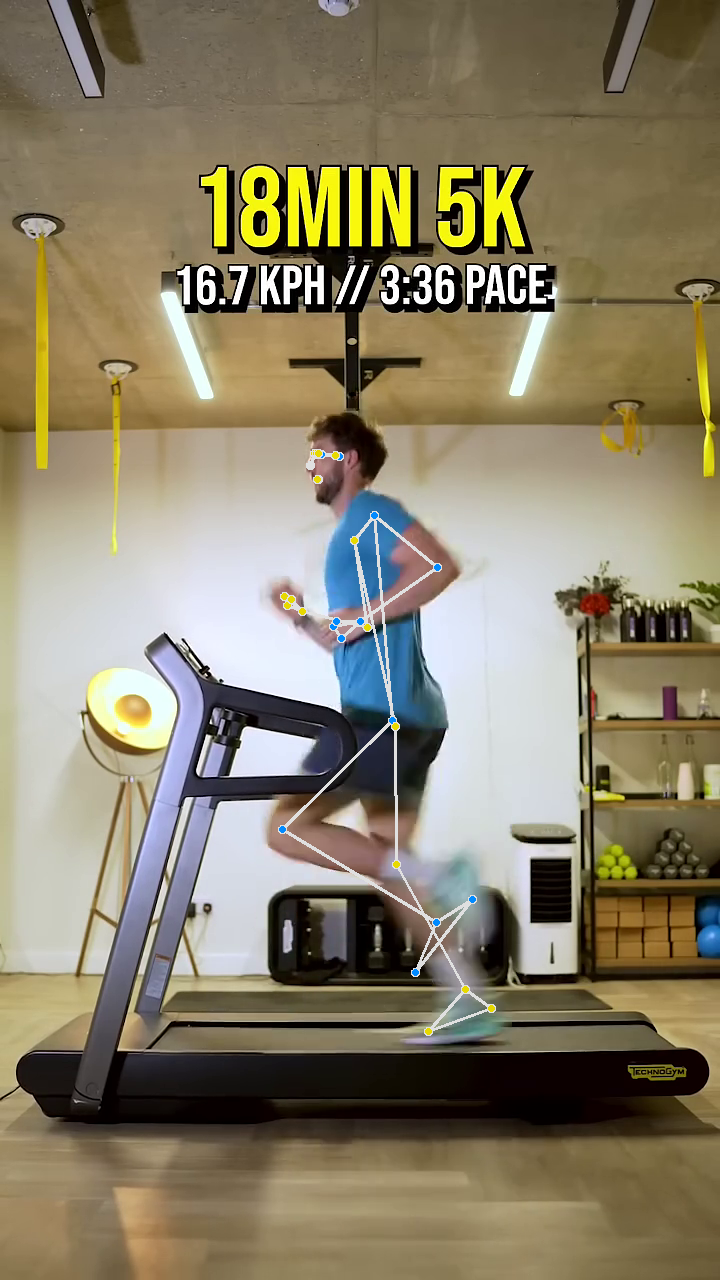

In [53]:
# @title Default title text
import os
from azure.storage.blob import BlobServiceClient, BlobClient
from urllib.parse import urlparse

print(f"Recently uploaded blob url: {blob_url}")
# blob_url = input("Paste blob url: ") #uncomment to take url from user
frame_number = int(input("Choose frame to visualize: "))

from azure.storage.blob import BlobServiceClient

def download_blob_from_url(blob_url):
  """Downloads a blob from Azure Blob Storage given its URL.

  Args:
      blob_url: The URL of the blob to download.
      download_path: The local path where the blob should be saved.
  """
  # create ./downloads directory if not exists
  if not os.path.exists('./downloads'):
    os.makedirs('./downloads')
  blob_name = blob_url.split('/')[-1]
  download_path = os.path.join('./downloads', blob_name)

  # check if blob already exists in download
  if os.path.exists(download_path):
    print(f"Blob already exists at {download_path}")
    return download_path

  try:
    # Parse the blob URL
    parsed_url = urlparse(blob_url)
    account_url = f"{parsed_url.scheme}://{parsed_url.netloc}"
    container_name = parsed_url.path.split('/')[1]  # Get container name
    blob_name = parsed_url.path.split('/')[-1]     # Get blob name

    # Create a BlobServiceClient object
    blob_service_client = BlobServiceClient(account_url=account_url, credential=DefaultAzureCredential())

    # Create a BlobClient object
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

    # Download the blob
    with open(download_path, "wb") as download_file:
      download_file.write(blob_client.download_blob().readall())

    print(f"Blob downloaded successfully to {download_path}")
  except Exception as e:
    print(f"An error occurred: {e}")
  return download_path

# download blob (blob_url) to file named as the blob name:

video_file = download_blob_from_url(blob_url)


import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow

# MediaPipe setup (same as before)
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)


# extract frame number X from video
def GetFrameFromVideo(video_file, frame_number):
  cap = cv2.VideoCapture(video_file)
  fps = cap.get(cv2.CAP_PROP_FPS)
  print(f"getting frame {frame_number}")
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
  ret, frame = cap.read()
  cap.release()
  return frame

frame = GetFrameFromVideo(video_file, frame_number)

print(frame.shape)
# cv2_imshow(frame)

image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
detection_result = detector.detect(image)

print(detection_result)

keypoints = detection_result.pose_landmarks[0]
landmarks = detection_result.pose_landmarks[0]
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
# 1280, 720,

# X * shape[1]
# Y * shape[0]
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End

    radians = np.arctan2(c[1]*1280-b[1]*1280, c[0]*720-b[0]*720) - np.arctan2(a[1]*1280-b[1]*1280, a[0]*720-b[0]*720)
    angle = np.abs(radians*180.0/np.pi)

    if angle >180.0:
        angle = 360-angle

    return angle

angle_knee = calculate_angle(hip, knee, ankle)
knee_angle = 180-angle_knee
print(angle_knee)
print(knee_angle)

hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

angle_knee = calculate_angle(hip, knee, ankle)
knee_angle = 180-angle_knee
print(angle_knee)
print(knee_angle)



k23 = keypoints[23]
k25 = keypoints[25]
k27 = keypoints[27]


# print(calculate_angle((k23.x, k23.y), (k25.x, k25.y), (k27.x, k27.y)))

annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))  # Display the frame
